# Black Friday Prediction Modeling - Full Project

In [123]:
# Step 1  -Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

In [159]:
#step 2   -Loading the dataset
df = pd.read_csv("C:/Users/Lenovo/Downloads/blackfriday dataset.csv")

### Basic EDA

In [162]:
# step 3
print("\nDataset Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nUnique Values in Each Column:")
for col in df.columns:
    print(f"{col}: {df[col].unique()[:10]}")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB

In [ ]:
# Step 3.1


# Visual exploration

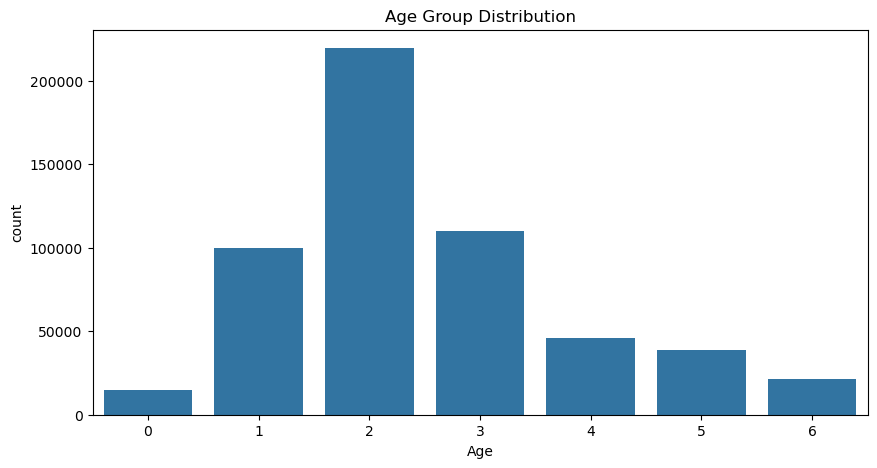

In [195]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Age')
plt.title("Age Group Distribution")
plt.show()

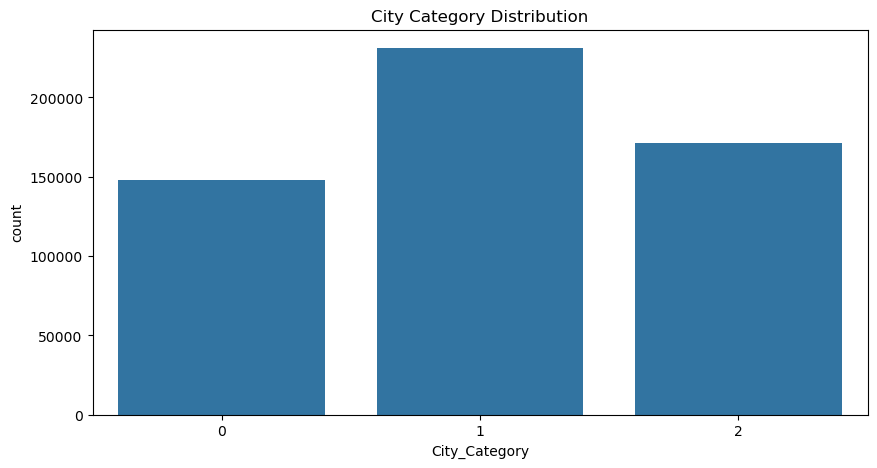

In [199]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='City_Category')
plt.title("City Category Distribution")
plt.show()

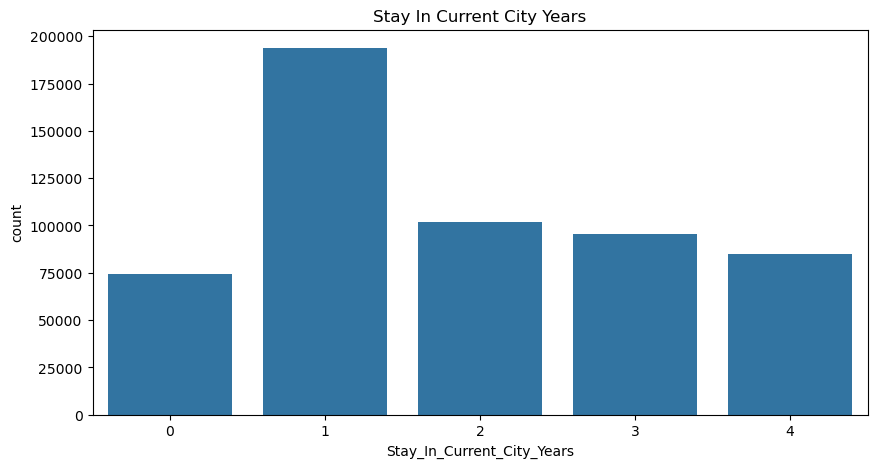

In [201]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Stay_In_Current_City_Years')
plt.title("Stay In Current City Years")
plt.show()

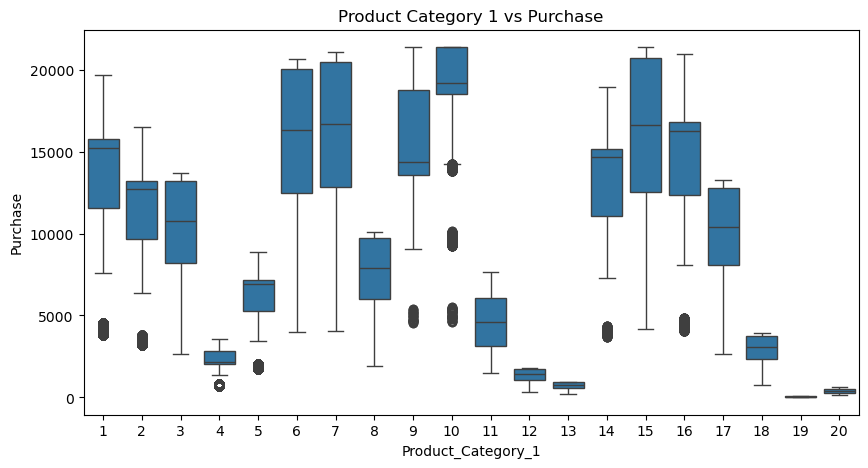

In [203]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='Product_Category_1', y='Purchase')
plt.title("Product Category 1 vs Purchase")
plt.show()

### Visualize Target Distribution

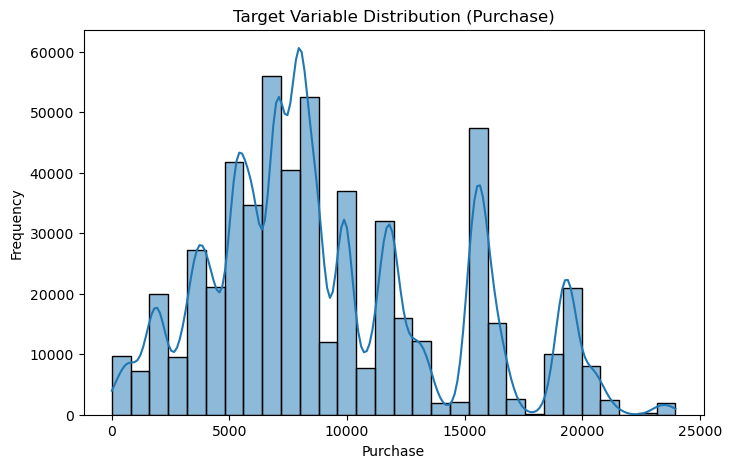

In [165]:
# step 4
plt.figure(figsize=(8,5))
sns.histplot(df['Purchase'], bins=30, kde=True)
plt.title("Target Variable Distribution (Purchase)")
plt.xlabel("Purchase")
plt.ylabel("Frequency")
plt.show()

In [167]:
# step 5   - Handling missing values
df['Product_Category_2'].fillna(0, inplace=True)
df['Product_Category_3'].fillna(0, inplace=True)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11228\1553349325.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Product_Category_2'].fillna(0, inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11228\1553349325.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [169]:
# step 6 -Encoding Categorical Features

le = LabelEncoder()
cat_cols = ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']
for col in cat_cols:
    df[col] = le.fit_transform(df[col])


In [171]:
# step 7    -Drop Irrelevant Columns
df.drop(['User_ID', 'Product_ID'], axis=1, inplace=True)

### Feature Engineering

In [174]:
# step 8
df['Total_Product_Categories'] = df[['Product_Category_1', 'Product_Category_2', 'Product_Category_3']].gt(0).sum(axis=1)
df['Product1x2'] = df['Product_Category_1'] * df['Product_Category_2']
df['Gender_Age'] = df['Gender'] * df['Age']


## Outlier Detection & Capping

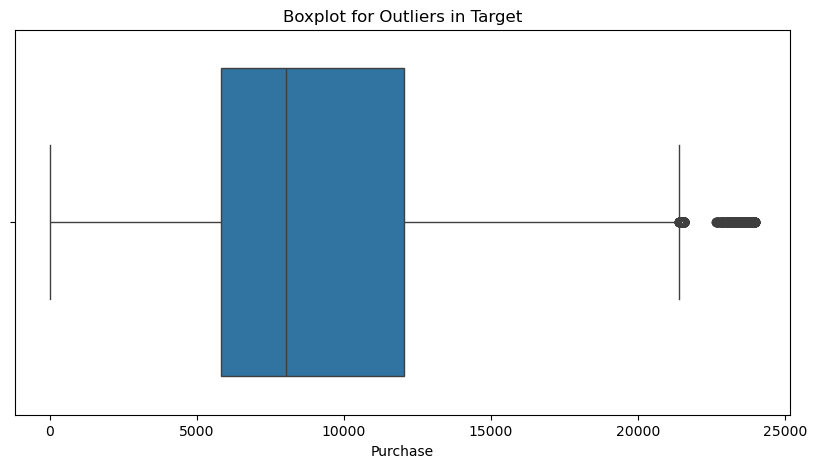

In [177]:
# step 9
plt.figure(figsize=(10,5))
sns.boxplot(x=df['Purchase'])
plt.title("Boxplot for Outliers in Target")
plt.show()

Q1 = df['Purchase'].quantile(0.25)
Q3 = df['Purchase'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['Purchase'] = np.where(df['Purchase'] > upper_bound, upper_bound,
                          np.where(df['Purchase'] < lower_bound, lower_bound, df['Purchase']))

### Correlation Heatmap

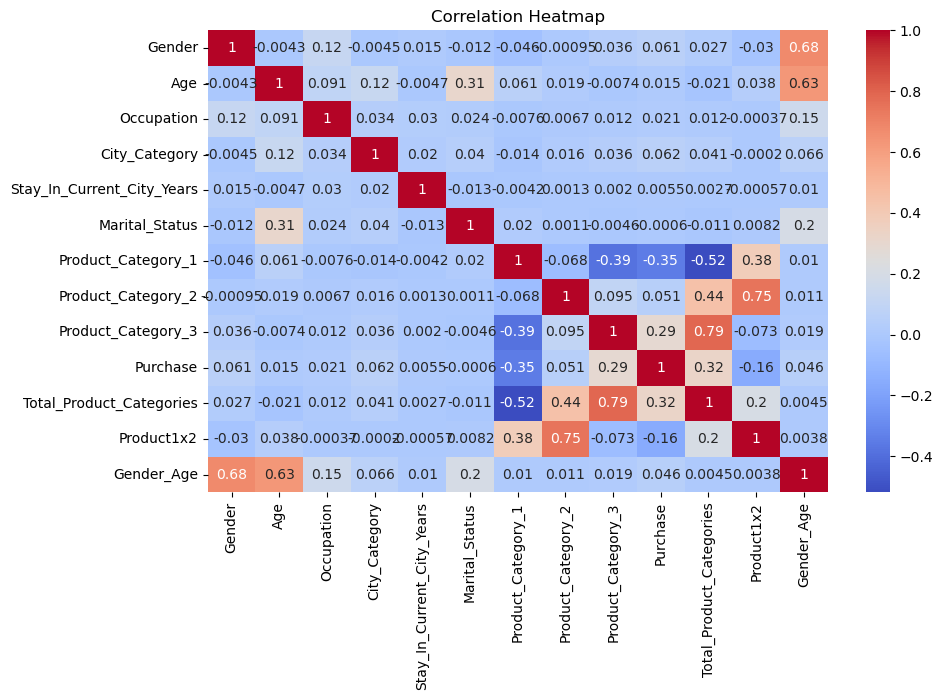

In [180]:
# step 10
numeric_df = df.select_dtypes(include=np.number)
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


## Train - Test split

In [183]:
# Step 11

X = df.drop('Purchase', axis=1)
y = df['Purchase']
y_log = np.log1p(y)

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

## Compare multiple models

In [186]:
# step 12
models = {
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=8, subsample=0.8, colsample_bytree=0.8, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=8, random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, iterations=200, learning_rate=0.05, depth=8, random_state=42)
}

best_model = None
best_r2 = -np.inf
r2_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train_log)
    preds_log = model.predict(X_test)
    preds = np.expm1(preds_log)
    actual = np.expm1(y_test_log)
    score = r2_score(actual, preds)
    r2_scores[name] = score
    print(f"{name} R² Score: {round(score, 4)}")
    if score > best_r2:
        best_r2 = score
        best_model = model
        best_name = name

print("\n" + "="*40)
print(f" Best Performing Model: {best_name}")
print(f" Best R2 Score: {round(best_r2, 4)}")
print("="*40 + "\n")

XGBoost R² Score: 0.655
RandomForest R² Score: 0.607
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 440054, number of used features: 12
[LightGBM] [Info] Start training from score 8.939269
LightGBM R² Score: 0.6461
CatBoost R² Score: 0.637

 Best Performing Model: XGBoost
 Best R2 Score: 0.655



### Improve R2 Score - Tune Best Model Immediately

In [188]:
# step 13
if best_name == "XGBoost":
    param_grid = {
        'max_depth': [6, 8],
        'learning_rate': [0.05, 0.1],
        'n_estimators': [200, 300]
    }
    grid = GridSearchCV(XGBRegressor(random_state=42), param_grid, scoring='r2', cv=3, verbose=1)
    grid.fit(X_train, y_train_log)
    best_model = grid.best_estimator_
    print("Tuned Parameters:", grid.best_params_)

elif best_name == "RandomForest":
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None]
    }
    grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, scoring='r2', cv=3, verbose=1)
    grid.fit(X_train, y_train_log)
    best_model = grid.best_estimator_
    print("Tuned Parameters:", grid.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Tuned Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300}


In [189]:
# Step 14  - Recalculate improved R2 score after tuning
preds_log = best_model.predict(X_test)
preds = np.expm1(preds_log)
actual = np.expm1(y_test_log)
final_r2 = r2_score(actual, preds)
print(f"\nImproved R2 Score After Tuning: {round(final_r2, 4)}")



Improved R2 Score After Tuning: 0.6629


### Visualize R2 comparison

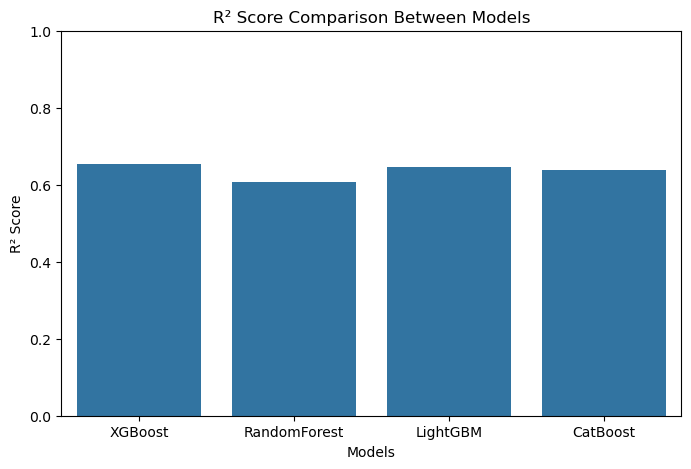

In [206]:
plt.figure(figsize=(8,5))
sns.barplot(x=list(r2_scores.keys()), y=list(r2_scores.values()))
plt.title("R² Score Comparison Between Models")
plt.ylabel("R² Score")
plt.xlabel("Models")
plt.ylim(0, 1)
plt.show()

### Feature importance for best model

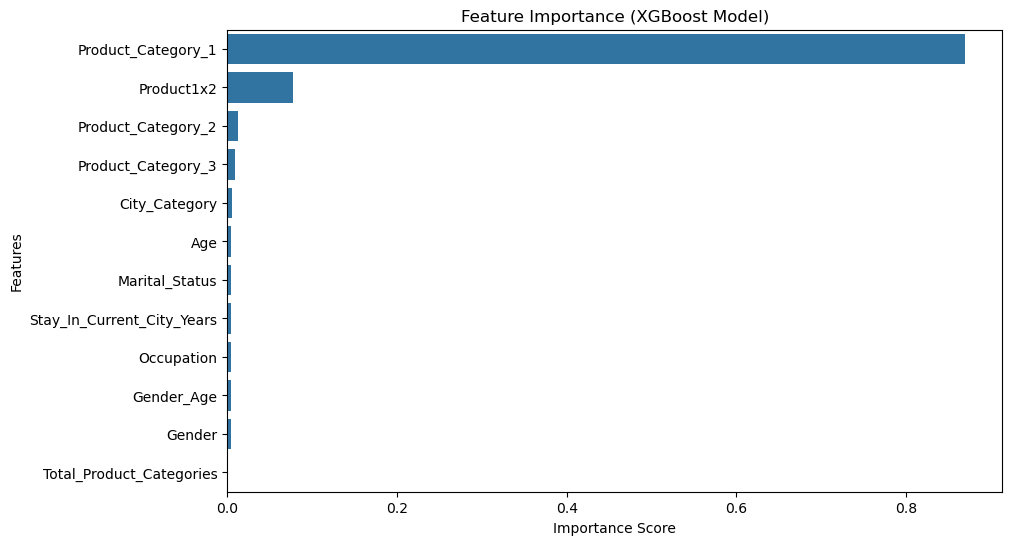

In [209]:
if hasattr(best_model, 'feature_importances_'):
    importance = pd.Series(best_model.feature_importances_, index=X.columns)
    importance = importance.sort_values(ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x=importance, y=importance.index)
    plt.title(f"Feature Importance ({best_name} Model)")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()

### Actual vs Predicted Comparison

         Actual     Predicted
84432   19142.0  13185.740234
72724   15513.0  12993.635742
197032   7802.0   6734.898926
353704  15455.0  12652.706055
91198    4492.0  15240.478516


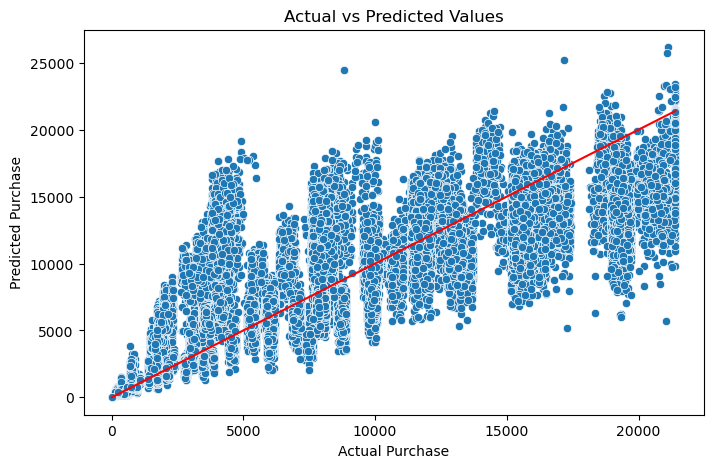

In [212]:
comparison_df = pd.DataFrame({"Actual": actual, "Predicted": preds})
print(comparison_df.head())

plt.figure(figsize=(8,5))
sns.scatterplot(x=actual, y=preds)
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Purchase")
plt.ylabel("Predicted Purchase")
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], color='red')
plt.show()
